# KNN

[KNN IN r](https://rpubs.com/davimat/knn_no_r)

## Carregando Biblioteca

In [2]:
library(repr)
library(caTools)
options(repr.plot.width = 4, repr.plot.height = 4)
library(class)
#Preprocessamento
library(CatEncoders)
library(gplots)
#Matricas
library(caret)

## Carregando os dados

In [3]:
df <- read.csv("../datasets/titanic/train.csv", na.strings = '')
head(df)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NA,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NA,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NA,S
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,NA,Q


## Pré-Processamento de Dados

In [4]:
# Extração de Pronomes
df$Name <- ifelse(grepl(", Mr. ", df$Name), 'Mr', as.character(df$Name))
df$Name <- ifelse(grepl("Capt", df$Name), 'Tripulacao', as.character(df$Name))
df$Name <- ifelse(grepl("Don", df$Name), 'Mr', as.character(df$Name))
df$Name <- ifelse(grepl("Major", df$Name), 'Tripulacao', as.character(df$Name))
df$Name <- ifelse(grepl("Col", df$Name), 'Tripulacao', as.character(df$Name))
df$Name <- ifelse(grepl("Dr", df$Name), 'Dr', as.character(df$Name))
df$Name <- ifelse(grepl("Rev", df$Name), 'Rev', as.character(df$Name))
df$Name <- ifelse(grepl("Sir", df$Name), 'Mr', as.character(df$Name))
df$Name <- ifelse(grepl("Jonkheer", df$Name), 'Mr', as.character(df$Name))
df$Name <- ifelse(grepl("Dona", df$Name), 'Mrs', as.character(df$Name))
df$Name <- ifelse(grepl("Countess", df$Name), 'Mrs', as.character(df$Name))
df$Name <- ifelse(grepl("Mme", df$Name), 'Mrs', as.character(df$Name))
df$Name <- ifelse(grepl("Lady", df$Name), 'Mrs', as.character(df$Name))
df$Name <- ifelse(grepl("Mrs", df$Name), 'Mrs', as.character(df$Name))
df$Name <- ifelse(grepl("Mlle", df$Name), 'Miss', as.character(df$Name))
df$Name <- ifelse(grepl("Ms", df$Name), 'Miss', as.character(df$Name))
df$Name <- ifelse(grepl("Miss", df$Name), 'Miss', as.character(df$Name))
df$Name <- ifelse(grepl("Master", df$Name), 'Master', as.character(df$Name))

# Categóricas para Numéricas
le_name <- LabelEncoder.fit(unique(df$Name))
df$Name <- transform(le_name, df$Name)

# Substituir valores ausentes/nulos
media <- mean(df$Age, na.rm = TRUE)
df$Age <- ifelse(is.na(df$Age), media, df$Age)

t <- table(df$Embarked)
moda <- names(t[t == max(t)])

df$Embarked <- ifelse(is.na(df$Embarked), as.character(moda), as.character(df$Embarked) )

# Categórico Para numérico
le_sex <- LabelEncoder.fit(unique(df$Sex))
df$Sex <- transform(le_sex, df$Sex)

le_embarked <- LabelEncoder.fit(unique(df$Embarked))
df$Embarked <- transform(le_embarked, df$Embarked)

# Remoção de colunas
df$PassengerId <- NULL
df$Ticket <- NULL
df$Cabin <- NULL

#Escalonamento 
df[, c('Age', 'Fare')] <- scale(df[, c('Age', 'Fare')])

df$Name = factor(df$Name)
df$Pclass = factor(df$Pclass)
df$Sex = factor(df$Sex)
df$Embarked = factor(df$Embarked)

head(df)
str(df)

Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,4,2,-0.5921480,1,0,-0.5021631,3
1,1,5,1,0.6384304,1,0,0.7864036,1
1,3,3,1,-0.2845034,0,0,-0.4885799,3
1,1,5,1,0.4076970,1,0,0.4204941,3
0,3,4,2,0.4076970,0,0,-0.4860644,3
0,3,4,2,0.0000000,0,0,-0.4778481,2


'data.frame':	891 obs. of  9 variables:
 $ Survived: int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass  : Factor w/ 3 levels "1","2","3": 3 1 3 1 3 3 1 3 3 2 ...
 $ Name    : Factor w/ 7 levels "1","2","3","4",..: 4 5 3 5 4 4 4 2 5 5 ...
 $ Sex     : Factor w/ 2 levels "1","2": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age     : num  -0.592 0.638 -0.285 0.408 0.408 ...
 $ SibSp   : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch   : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Fare    : num  -0.502 0.786 -0.489 0.42 -0.486 ...
 $ Embarked: Factor w/ 3 levels "1","2","3": 3 1 3 3 3 2 3 3 3 1 ...


# Divisão dos dados em treino e teste

In [5]:
set.seed(0)
divisao <- sample.split(df$Survived, SplitRatio = 0.75)

treino <- subset(df, divisao == TRUE)
teste <-  subset(df, divisao == FALSE)

x_train <- treino[,-1]
y_train <- treino$Survived

x_test <- teste[,-1]
y_test <- teste$Survived

## KNN

Argumentos

- **train** - Matriz ou quadro de dados de casos de conjunto de treinamento.
- **test** - Matriz ou quadro de dados de casos de conjunto de teste. Um vetor será interpretado como um vetor linha para um único caso.
- **cl** - Fator de classificações verdadeiras do conjunto de treinamento
- **k** - número de vizinhos considerados.
- **I** - Voto mínimo para decisão definitiva, caso contrário, dúvida. (Mais precisamente, menos de k-l votos divergentes são permitidos, mesmo se k for aumentado por empates.)
- ***prob** - Se isso for verdade, a proporção dos votos da classe vencedora é retornada como atributo prob.
- **use.all**  - Controla o manuseio de laços. Se verdadeiro, todas as distâncias iguais ao k-ésimo maior serão incluídas. Se falso, uma seleção aleatória de distâncias iguais ao k-ésimo é escolhida para usar exatamente k vizinhos. 

In [6]:
previsoes <- knn(train = x_train, test = x_test, cl = y_train, k = 1)

acuracia = 100 * sum(previsoes == y_test)/length(y_test)

acuracia

[1] 72.64574

# Matriz de Confusão

- A função **table** realiza o agrupamento dos dados
- A função **confusionMatriz** da biblioteca **caret** também calcula a matriz de confusão + as métricas

In [7]:
matriz_confusao = table(y_test, previsoes)
matriz_confusao

      previsoes
y_test   0   1
     0 107  30
     1  31  55

In [8]:
matriz = confusionMatrix(factor(previsoes), factor(y_test))
matriz

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 107  31
         1  30  55
                                          
               Accuracy : 0.7265          
                 95% CI : (0.6629, 0.7838)
    No Information Rate : 0.6143          
    P-Value [Acc > NIR] : 0.000288        
                                          
                  Kappa : 0.4215          
                                          
 Mcnemar's Test P-Value : 1.000000        
                                          
            Sensitivity : 0.7810          
            Specificity : 0.6395          
         Pos Pred Value : 0.7754          
         Neg Pred Value : 0.6471          
             Prevalence : 0.6143          
         Detection Rate : 0.4798          
   Detection Prevalence : 0.6188          
      Balanced Accuracy : 0.7103          
                                          
       'Positive' Class : 0               
                              

## Personalizando a Matriz de Confusão

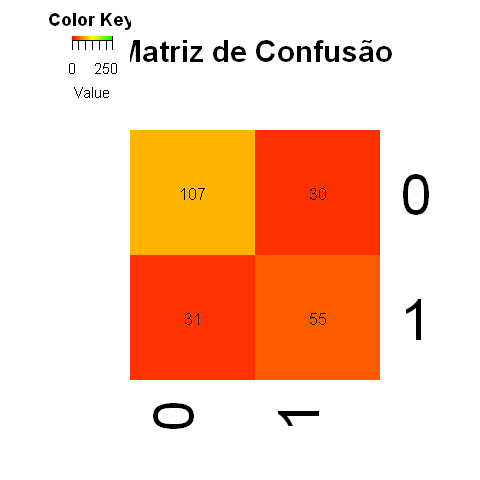

In [9]:
my_palette <- colorRampPalette(c("red", "yellow", "green"))

col_breaks = c(0:50, 51:100, 101:300)

heatmap.2(matriz_confusao,
    Rowv = 'NA',
    cellnote = matriz_confusao, 
    main = "Matriz de Confusão",
    notecol="black",      
    density.info="none",  
    trace="none",        
    col=my_palette,       
    breaks=col_breaks,   
    dendrogram= 'none',     
    Colv="NA" 
)

# Métricas

- **Precisão** que é a fração de instâncias recuperadas que são relevantes, 
- **Recall** - que é a fração de instâncias relevantes que são recuperadas 
- **f-score** - é 2 * precisão * recall / (precisão + recall) é 

In [10]:
precision(factor(previsoes), factor(y_test))
'Morto'
precision(factor(previsoes), factor(y_test), relevant = 2)
'Vivo'
precision(factor(previsoes), factor(y_test), relevant = 1)

[1] 0.7753623

[1] "Morto"

[1] 0.6470588

[1] "Vivo"

[1] 0.7753623

In [11]:
recall(factor(previsoes), factor(y_test))
'Morto'
recall(factor(previsoes), factor(y_test), relevant = 2)
'Vivo'
recall(factor(previsoes), factor(y_test), relevant = 1)

[1] 0.7810219

[1] "Morto"

[1] 0.6395349

[1] "Vivo"

[1] 0.7810219

In [12]:
F_meas(factor(previsoes), factor(y_test))
'Morto'
F_meas(factor(previsoes), factor(y_test), relevant = 2)
'Vivo'
F_meas(factor(previsoes), factor(y_test), relevant = 1)

[1] 0.7781818

[1] "Morto"

[1] 0.6432749

[1] "Vivo"

[1] 0.7781818

# Melhor K

- No lugar de ficar “chutando” valores,pode-se automatizar o processo com um loop. Uma forma de fazer isso é a seguinte:
- Perceba que o loop acima cria a variável perc.erro que armazena os erros de previsão para valores de k de 1 até 20.
- Quando colocado num gráfico k x perc.erro fica melhor a visualização:
- Depois de olhar o erro global ainda seria interessante analisar a matriz de confusão

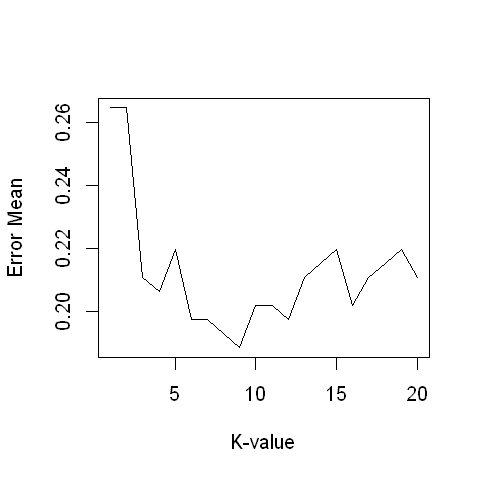

In [13]:
previsoes = NULL
perc.erro = NULL

for(i in 1:20){
    set.seed(1)
    previsoes <- knn(train = x_train, test = x_test, cl= y_train, k=i)
    perc.erro[i] <- mean(y_test != previsoes)
}

plot(perc.erro, type = 'l', xlab = 'K-value', ylab = 'Error Mean')

In [14]:
previsoes <- knn(train = x_train, test = x_test, cl= y_train, k=9)
acuracia = 100 * sum(previsoes == y_test)/length(y_test)
acuracia

[1] 81.16592

In [15]:
matriz_confusao = table(y_test, previsoes)
matriz_confusao

      previsoes
y_test   0   1
     0 119  18
     1  24  62

# Validação Cruzada

- **method = cv** - indica que iremos usar o método crossvalidation
- **number = 10** - define o número de fold
- **method = xgbTree** - indica que iremos usar o algorítmo de de Boost

In [23]:
controle_treinamento = trainControl(method = 'cv', number = 10)
df$Survived = factor(df$Survived)
modelo = train(Survived ~ ., data = df, trControl = controle_treinamento, method = 'knn')
modelo$results

k,Accuracy,Kappa,AccuracySD,KappaSD
5,0.8147566,0.6041950,0.04643530,0.1018217
7,0.8125218,0.5984588,0.04985463,0.1064061
9,0.8147566,0.5995737,0.05319354,0.1143758
